In [2]:
#Libraries
import numpy as np 
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date
import pandas_datareader as data
from pandas_datareader import *
import math
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold


#Model Result Analysis
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

In [3]:
#Scraping Dataset from Yahoo Finance using yfinance
#Getting data for the Apple Stock
aapl = yf.Ticker("AAPL")

# Apple Company Information
# aapl.info

# Apple's Historical Stock Prices (10 Year Period)
aapl.dataset = aapl.history(period="10y")

aapl.dataset.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-04-20,168.759995,168.880005,166.100006,167.229996,67929800,0.0,0.0
2022-04-21,168.910004,171.529999,165.910004,166.419998,87227800,0.0,0.0
2022-04-22,166.460007,167.869995,161.500000,161.789993,84882400,0.0,0.0
2022-04-25,161.119995,163.169998,158.460007,162.880005,96046400,0.0,0.0
2022-04-26,162.250000,162.339996,156.720001,156.800003,95623200,0.0,0.0
2022-04-27,155.910004,159.789993,155.380005,156.570007,88063200,0.0,0.0
2022-04-28,159.250000,164.520004,158.929993,163.639999,130216800,0.0,0.0
2022-04-29,161.839996,166.199997,157.250000,157.649994,131587100,0.0,0.0
2022-05-02,156.710007,158.229996,153.270004,157.960007,123055300,0.0,0.0


In [4]:
#Dataframe basic information on rows and columns
aapl.dataset.shape

(2516, 7)

In [5]:
#Dropped Columns 'Dividends' and 'Stock Splits'
aapl.dataset.drop(['Dividends', 'Stock Splits'], axis=1)

,Open,High,Low,Close,Volume
Date,,,,,
2012-05-04,17.647808,17.686951,17.283585,17.286032,529992400
2012-05-07,17.171361,17.516012,17.163104,17.415400,460118400
2012-05-08,17.418454,17.477170,17.086649,17.375641,497252000
2012-05-09,17.238635,17.553011,17.151479,17.406219,480704000
2012-05-10,17.571363,17.611119,17.383596,17.447203,333200000
...,...,...,...,...,...
2022-04-27,155.910004,159.789993,155.380005,156.570007,88063200
2022-04-28,159.250000,164.520004,158.929993,163.639999,130216800
2022-04-29,161.839996,166.199997,157.250000,157.649994,131587100


In [6]:
#YFinance Bug- Dropped columns appears after being dropped so copying into new dataset
dataset = aapl.dataset [['Open', 'Close', 'High', 'Low','Volume']].copy()
dataset.tail()

,Open,Close,High,Low,Volume
Date,,,,,
2022-04-27,155.910004,156.570007,159.789993,155.380005,88063200
2022-04-28,159.250000,163.639999,164.520004,158.929993,130216800
2022-04-29,161.839996,157.649994,166.199997,157.250000,131587100
2022-05-02,156.710007,157.960007,158.229996,153.270004,123055300
2022-05-03,158.149994,159.479996,160.649994,156.320007,86935951


ADDING TECHNICAL INDICATORS TO DATASET

Stochastic Oscillator Indicator

In [7]:
# Calculating %K and %D
dataset['14-high'] = dataset['High'].rolling(14).max()
dataset['14-low'] = dataset['Low'].rolling(14).min()
dataset['%K'] = (dataset['Close'] - dataset['14-low'])*100/(dataset['14-high'] - dataset['14-low'])
dataset['%D'] = dataset['%K'].rolling(3).mean()


In [8]:
#Dropping 14-HIGH AND 14-LOW COLUMNS
dataset.drop(['14-high', '14-low'], axis = 1, inplace=True)

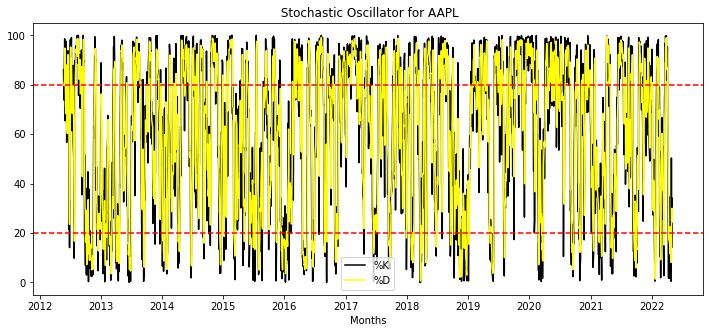

In [9]:
#Plotting SO Graph
plt.figure(figsize=(12, 5))
plt.title(' Stochastic Oscillator for AAPL')
plt.xlabel('Months')
plt.plot(dataset['%K'], label='%K', c='black')
plt.plot(dataset['%D'], label='%D',  c='yellow')
plt.axhline(20, linestyle='--', color="r")
plt.axhline(80, linestyle="--", color="r")
plt.legend()
plt.show()


In [10]:
# Adding Buy/Sell Signals from Sotchastic Oscillator Indicator
def categorise_so(row):  
    if row['%K'] <= 20 and row['%D'] <= 20:
        return 'Buy'
    elif row['%K'] >= 80 and  row['%D']>= 80:
        return 'Sell'
    else:
        return 'Hold'

    
   
dataset['SO Indicator'] = dataset.apply(lambda row: categorise_so(row), axis=1)


In [11]:
# Distrubition of the Indicator
print(dataset['SO Indicator'].value_counts())

Hold    1552
Sell     725
Buy      239
Name: SO Indicator, dtype: int64


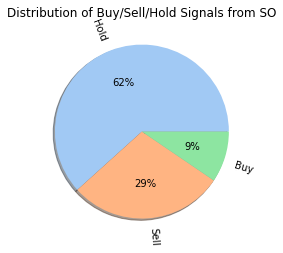

In [12]:
#Distrubition of the SO Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['SO Indicator'].value_counts().tolist()
colours = sns.color_palette("pastel")
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals from SO")
plt.show()

Relative Strength Index

In [13]:
delta = dataset['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
dataset['RSI'] = 100 - (100/(1 + rs))

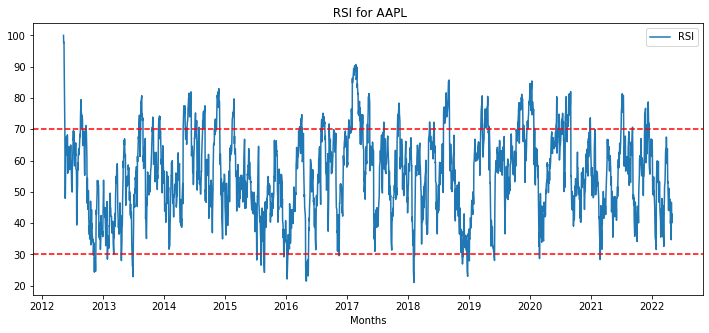

In [14]:
#Plotting RSI Graph
plt.figure(figsize=(12, 5))
plt.title(' RSI for AAPL')
plt.xlabel('Months')
plt.plot(dataset['RSI'], label='RSI')
plt.axhline(30, linestyle='--', color="r")
plt.axhline(70, linestyle="--", color="r")
plt.legend()
plt.show()



In [15]:
# Adding Buy/Sell Signals from RSI Indicator
def categorise_rsi(row):  
    if row['RSI'] <= 30:
        return 'Buy'
    elif row['RSI'] >= 70:
        return 'Sell'
    else:
        return 'Hold'
  
dataset['RSI Indicator'] = dataset.apply(lambda row: categorise_rsi(row), axis=1)

In [16]:
# Distrubition of the Indicator
print(dataset['RSI Indicator'].value_counts())

Hold    2085
Sell     369
Buy       62
Name: RSI Indicator, dtype: int64


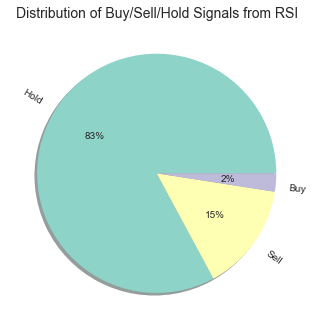

In [17]:
#Distrubition of the Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['RSI Indicator'].value_counts().tolist()
plt.style.use("seaborn")
colours = sns.color_palette("Set3")
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals from RSI", fontdict={'fontsize': 14})
plt.show()

Bollinger Bands

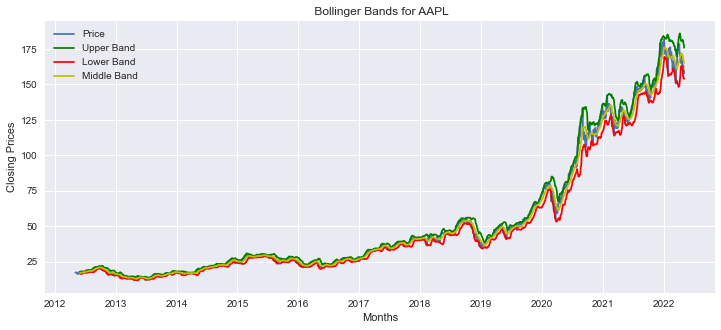

In [18]:
def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate=20):
    # SMA for 20 Days (Middle Band)
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()

    # Calculating Upper Band
    bollinger_upper = sma + (std * 2 )

    # Calculate Lower Band
    bollinger_lower = sma - (std * 2 )

    #Middle Band
    bollinger_middle = sma
    return bollinger_upper, bollinger_lower, bollinger_middle


closing_prices = dataset['Close']
bollinger_upper, bollinger_lower, bollinger_middle = get_bollinger_bands(closing_prices)

#Plotting the  Bollinger Bands
plt.figure(figsize=(12, 5))
plt.title(' Bollinger Bands for AAPL')
plt.xlabel('Months')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Price')
plt.plot(bollinger_upper, label='Upper Band', c='g')
plt.plot(bollinger_lower, label='Lower Band', c='r')
plt.plot(bollinger_middle, label='Middle Band', c='y')

plt.legend()
plt.show()

In [19]:
#Adding Bollinger Bands to the Dataset
dataset['Bollinger_Upper'] = bollinger_upper
dataset['Bollinger_Lower'] = bollinger_lower


In [20]:
# Adding Buy/Sell Signals from Bollinger Bands Indicator
def categorise_bollinger(row):  
    if row['Close'] < row['Bollinger_Lower']:
        return 'Buy'
    elif row['Close'] > row['Bollinger_Upper']:
        return 'Sell'
    else:
        return 'Hold'
    
   
dataset['Bollinger Indicator'] = dataset.apply(lambda row: categorise_bollinger(row), axis=1)


In [21]:
# Distrubition of the Indicator
print(dataset['Bollinger Indicator'].value_counts())

Hold    2218
Sell     188
Buy      110
Name: Bollinger Indicator, dtype: int64


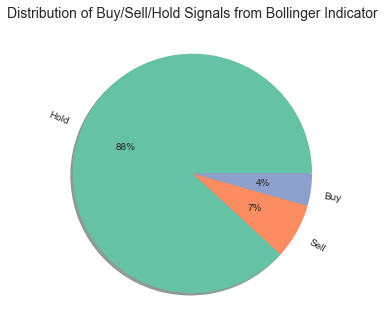

In [22]:
#Distrubition of the Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['Bollinger Indicator'].value_counts().tolist()
plt.style.use("seaborn")
colours = sns.color_palette("Set2")
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals from Bollinger Indicator", fontdict={'fontsize': 14})
plt.show()

Moving Average Convergence Divergence

In [23]:
# Calculating the MACD Line and the Signal Line
ema12 = dataset['Close'].ewm(span=12, adjust=False).mean()
ema26 = dataset['Close'].ewm(span=26, adjust=False).mean()
macd = ema12 - ema26
signal = macd.ewm(span=9, adjust=False).mean()


#Appeding the MACD and Signal Data to Dataset
dataset['MACD'] = macd
dataset['Signal'] = signal


In [24]:
# Adding Buy/Sell Signals from MACD
signal = []

for i in range(len(dataset)):
   if dataset['MACD'][i] > dataset['Signal'][i] and dataset['MACD'][i-1] < dataset['Signal'][i-1]:
      signal.append('Buy')
   elif dataset['MACD'][i] < dataset['Signal'][i] and dataset['MACD'][i-1] > dataset['Signal'][i-1]:
      signal.append('Sell')
   else:
      signal.append('Hold')

  
    
dataset['MACD Indicator'] = signal

In [25]:
# Distrubition of the Indicator
print(dataset['MACD Indicator'].value_counts())

Hold    2341
Sell      88
Buy       87
Name: MACD Indicator, dtype: int64


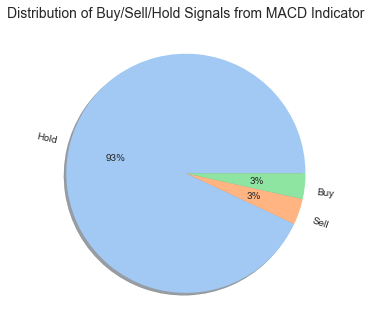

In [26]:
#Distrubition of the MACD Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['MACD Indicator'].value_counts().tolist()
colours = sns.color_palette("pastel", 10)
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals from MACD Indicator", fontdict={'fontsize': 14})
plt.show()

Addding Target Variable

In [27]:
# Recommender Based on the three indicators
def recommender(row): 
    # If All Share the Same Signal OutPut That Signal (Buy)
    if row['RSI Indicator'] == "Buy" and row['SO Indicator'] == 'Buy' and  row['Bollinger Indicator'] == 'Buy':
        return 'Buy'
     # If Any 2 Indicators Share the Same Signal Output That Signal (buy)
    elif row['RSI Indicator'] == 'Buy' and row['SO Indicator'] == 'Buy':
        return 'Buy'
    elif row['RSI Indicator'] == 'Buy' and row['Bollinger Indicator'] == 'Buy':
        return 'Buy'
    elif row['SO Indicator'] == 'Buy' and row['Bollinger Indicator'] == 'Buy':
        return 'Buy'   
    # If All Share the Same Signal Output That Signal (Sell)
    elif row['RSI Indicator'] == 'Sell' and row['SO Indicator'] == 'Sell' and  row['Bollinger Indicator'] == 'Sell':
        return 'Sell'
    # If Any 2 Indicators Share the Same Signal Output That Signal (Sell)
    elif row['RSI Indicator'] == 'Sell' and row['SO Indicator'] == 'Sell':
        return 'Sell'
    elif row['RSI Indicator'] == 'Sell' and row['Bollinger Indicator'] == 'Sell':
        return 'Sell'
    elif row['SO Indicator'] == 'Sell' and row['Bollinger Indicator'] == 'Sell':
        return 'Sell'    
    # If All Share the Same Signal OutPut That Signal (Hold)
    elif row['RSI Indicator'] == 'Hold' and row['SO Indicator'] == 'Hold' and  row['Bollinger Indicator'] == 'Hold':
        return 'Hold'
    # If Any 2 Indicators Share the Same Signal Output That Signal (Hold)
    elif row['RSI Indicator'] == 'Hold' and row['SO Indicator'] == 'Hold':
        return 'Hold'
    elif row['RSI Indicator'] == 'Hold' and row['Bollinger Indicator'] == 'Hold':
        return 'Hold'
    elif row['SO Indicator'] == 'Hold' and row['Bollinger Indicator'] == 'Hold':
        return 'Hold'      
    else:
        return 'Unclassed'

dataset['Recommender'] = dataset.apply(lambda row: recommender(row), axis=1)

In [28]:
# Distrubition of the Recommender
print(dataset['Recommender'].value_counts())


Hold    2015
Sell     390
Buy      111
Name: Recommender, dtype: int64


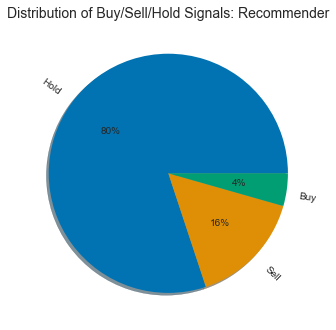

In [29]:
#Distrubition of the Recommender
labels = ["Hold", "Sell", "Buy"]
values = dataset['Recommender'].value_counts().tolist()
plt.style.use("seaborn")
colours = sns.color_palette("colorblind" )
plt.pie(x=values, labels=labels, autopct='%.0f%%', colors= colours, shadow=True, rotatelabels='true')
plt.title("Distribution of Buy/Sell/Hold Signals: Recommender", fontdict={'fontsize': 14})
plt.show()

Data Cleaning and Preprocessing

In [30]:
dataset.drop(['RSI Indicator', 'SO Indicator', 'MACD Indicator' , 'Bollinger Indicator'], axis = 1, inplace=True)

In [31]:
#Dataset shape after adding all the technical indicators 
dataset.shape

(2516, 13)

In [32]:
#Columns After Adding All The Technical Indicators
dataset.columns

Index(['Open', 'Close', 'High', 'Low', 'Volume', '%K', '%D', 'RSI',
       'Bollinger_Upper', 'Bollinger_Lower', 'MACD', 'Signal', 'Recommender'],
      dtype='object')

In [33]:
#Information regarding the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2012-05-04 to 2022-05-03
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2516 non-null   float64
 1   Close            2516 non-null   float64
 2   High             2516 non-null   float64
 3   Low              2516 non-null   float64
 4   Volume           2516 non-null   int64  
 5   %K               2503 non-null   float64
 6   %D               2501 non-null   float64
 7   RSI              2515 non-null   float64
 8   Bollinger_Upper  2497 non-null   float64
 9   Bollinger_Lower  2497 non-null   float64
 10  MACD             2516 non-null   float64
 11  Signal           2516 non-null   float64
 12  Recommender      2516 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 275.2+ KB


In [34]:
#Checking for Null Values
dataset.isna().sum()

Open                0
Close               0
High                0
Low                 0
Volume              0
%K                 13
%D                 15
RSI                 1
Bollinger_Upper    19
Bollinger_Lower    19
MACD                0
Signal              0
Recommender         0
dtype: int64

In [35]:
#Dropping Null Values
dataset = dataset.dropna()
dataset.isna().sum()

Open               0
Close              0
High               0
Low                0
Volume             0
%K                 0
%D                 0
RSI                0
Bollinger_Upper    0
Bollinger_Lower    0
MACD               0
Signal             0
Recommender        0
dtype: int64

In [36]:
#let's check if there is any duplicate data
print(dataset.duplicated().any())
print(dataset.duplicated().sum())

False
0


In [37]:
#Dataframe after dopping null values
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2497 entries, 2012-06-01 to 2022-05-03
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2497 non-null   float64
 1   Close            2497 non-null   float64
 2   High             2497 non-null   float64
 3   Low              2497 non-null   float64
 4   Volume           2497 non-null   int64  
 5   %K               2497 non-null   float64
 6   %D               2497 non-null   float64
 7   RSI              2497 non-null   float64
 8   Bollinger_Upper  2497 non-null   float64
 9   Bollinger_Lower  2497 non-null   float64
 10  MACD             2497 non-null   float64
 11  Signal           2497 non-null   float64
 12  Recommender      2497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 273.1+ KB


In [38]:
# #Encode Categorical Variables
signal_dict = {'Hold': 0, 'Sell': 1, 'Buy': 2}

dataset['Recommender'] = dataset['Recommender'].map(signal_dict)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2497 entries, 2012-06-01 to 2022-05-03
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2497 non-null   float64
 1   Close            2497 non-null   float64
 2   High             2497 non-null   float64
 3   Low              2497 non-null   float64
 4   Volume           2497 non-null   int64  
 5   %K               2497 non-null   float64
 6   %D               2497 non-null   float64
 7   RSI              2497 non-null   float64
 8   Bollinger_Upper  2497 non-null   float64
 9   Bollinger_Lower  2497 non-null   float64
 10  MACD             2497 non-null   float64
 11  Signal           2497 non-null   float64
 12  Recommender      2497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 273.1 KB


In [39]:
# #Splitting the dataset into training and test sets
# #Feature Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE

#Independant and Dependent Variable
y=dataset.iloc[:,12:13] #Dependent variable
X=dataset.iloc[:,0:12] #Independent variable

#Spliting the data into train and test
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)


#Scaling
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
# Shape of Training and Test sets
print("x_train dataset: ", X_train.shape)
print(" y_train dataset: ", y_train.shape)
print(" x_test dataset: ", X_test.shape)
print("y_test dataset: ", y_test.shape)

x_train dataset:  (1747, 12)
 y_train dataset:  (1747, 1)
 x_test dataset:  (750, 12)
y_test dataset:  (750, 1)


In [41]:
y_train['Recommender'].value_counts()


0    1401
1     265
2      81
Name: Recommender, dtype: int64

In [42]:
y_test['Recommender'].value_counts()

0    595
1    125
2     30
Name: Recommender, dtype: int64

Text(0.5, 0, 'Trade Signals')

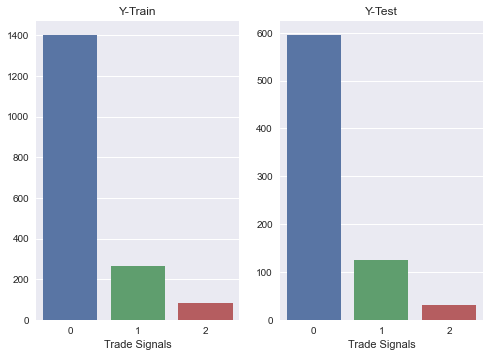

In [43]:
#Original Dataset  
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(x=['0', '1','2'], y =[sum(y_train['Recommender'] == 0), sum(y_train['Recommender'] == 1), sum(y_train['Recommender'] == 2)], ax = ax1)
ax1.set_title("Y-Train")
ax1.set_xlabel('Trade Signals')

sns.barplot(x=['0', '1', '2'], y =[sum(y_test['Recommender'] == 0), sum(y_test['Recommender'] == 1), sum(y_test['Recommender'] == 2)], ax = ax2)
ax2.set_title("Y-Test")
ax2.set_xlabel('Trade Signals')

Text(0.5, 0, 'Trade Signals')

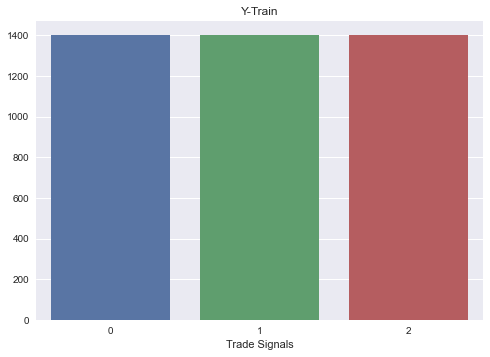

In [44]:
#Handling Imbalance data using SMOTE
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE


oversample = SMOTE()
Xsmote, ysmote = oversample.fit_resample(X_train, y_train)


fig = sns.barplot(x=['0', '1', '2'],  y =[sum(ysmote['Recommender'] == 0), sum(ysmote['Recommender'] == 1), sum(ysmote['Recommender'] == 2)])
fig.set_title("Y-Train")
fig.set_xlabel('Trade Signals')

Exploring Models on Original Dataset without using SMOTE

In [45]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
k = 10
#Logistic Regression
lr = LogisticRegression(multi_class = "ovr")
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
     
    lr.fit(X_train,y_train.values.ravel())
    y_pred = lr.predict(X_test)

    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)


#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))

#Storing Results for the Model
list_1 = []
list_2 = []

#Results
list_2.append("Logistic Regression")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []



C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\User

Accuracy of each fold - [0.892, 0.908, 0.896, 0.908, 0.884, 0.868, 0.856, 0.9076305220883534, 0.9036144578313253, 0.9196787148594378]
Precision of each fold - [0.6270190895741556, 0.632286995515695, 0.6283185840707964, 0.6219899100223644, 0.6110579071697632, 0.5897969085742011, 0.582516898306372, 0.6321321321321322, 0.6031586021505376, 0.6362252663622526]
Recall of each fold - [0.5299145299145299, 0.5641025641025641, 0.5384615384615384, 0.570982905982906, 0.5197008547008547, 0.4923931623931624, 0.4752823948803848, 0.5641025641025641, 0.5761714555684405, 0.5897435897435898]
F1 of each fold - [0.5595678779179573, 0.5879360985743964, 0.5669572993516656, 0.5896325275953612, 0.5472539094961094, 0.5188034188034188, 0.500828655439722, 0.5878499964010652, 0.5864030335861322, 0.6072394424797171]
Avg Accuracy : 0.8943
Avg Recall : 0.5421
Avg Precision: 0.6165
Avg F1 : 0.5652


C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
k = 10

#Decision Tree
decision_tree = DecisionTreeClassifier()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
     
    decision_tree.fit(X_train,y_train)
    y_pred = decision_tree.predict(X_test)

    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)


#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))


#Results
list_2.append("Decision Tree")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []



Accuracy of each fold - [0.944, 0.916, 0.932, 0.952, 0.924, 0.92, 0.92, 0.8955823293172691, 0.9558232931726908, 0.9678714859437751]
Precision of each fold - [0.8813041743734812, 0.8254720731464918, 0.862151067323481, 0.8649999999999999, 0.850937619594336, 0.8581790611493583, 0.8407665505226479, 0.7674510650546921, 0.9030781499202551, 0.8849664991624792]
Recall of each fold - [0.8998679098679099, 0.8664452214452215, 0.8593512043512043, 0.8516938616938616, 0.8777738927738928, 0.8474708624708626, 0.7810097496027145, 0.7571931139770336, 0.8968306958256708, 0.8720877112836911]
F1 of each fold - [0.8877907758504774, 0.8447740624902121, 0.8594209702204091, 0.8577918424753866, 0.8619839290662233, 0.8526347528704167, 0.8082321745688082, 0.7548623200036215, 0.899901268322321, 0.8779693121020008]
Avg Accuracy : 0.9327
Avg Recall : 0.851
Avg Precision: 0.8539
Avg F1 : 0.8505


In [47]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
k = 10

#Random Forest
rf= RandomForestClassifier()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
     
    rf.fit(X_train,y_train.values.ravel())
    y_pred = rf.predict(X_test)

    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)


#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))


#Results
list_2.append("Random Forest")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []

Accuracy of each fold - [0.944, 0.956, 0.956, 0.976, 0.948, 0.924, 0.948, 0.9518072289156626, 0.9558232931726908, 0.963855421686747]
Precision of each fold - [0.9601190476190476, 0.9470139996455785, 0.9165818877440112, 0.9501633986928105, 0.9096082779009609, 0.849960876369327, 0.9795597484276729, 0.9583388266315095, 0.9825396825396826, 0.9072530060023546]
Recall of each fold - [0.828834498834499, 0.8475951825951826, 0.8831118881118881, 0.8685742035742036, 0.8946542346542347, 0.7277117327117327, 0.8311965811965812, 0.8310277104246954, 0.7536907536907537, 0.8566687360657209]
F1 of each fold - [0.8843431147432305, 0.891504528392851, 0.8983769711319178, 0.9030012023758767, 0.8995258543567722, 0.77775070777642, 0.8928179544323812, 0.8809372165286704, 0.8174614712512023, 0.8795316902548823]
Avg Accuracy : 0.9523
Avg Recall : 0.8323
Avg Precision: 0.9361
Avg F1 : 0.8725


In [48]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
k = 10 
#Support Vector Machine
svc = SVC()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
     
    svc.fit(X_train,y_train.values.ravel())
    y_pred = svc.predict(X_test)
    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)


#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))


#Results
list_2.append("Support Vector Machine")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []

Accuracy of each fold - [0.904, 0.944, 0.936, 0.948, 0.932, 0.892, 0.9, 0.9477911646586346, 0.9317269076305221, 0.9357429718875502]
Precision of each fold - [0.9050314465408805, 0.9414344685242518, 0.9070683721169157, 0.950278134360291, 0.8933680877907114, 0.8122461069735952, 0.869138634046891, 0.9102451966529638, 0.9440789473684211, 0.8777351520318272]
Recall of each fold - [0.7708857808857809, 0.8494755244755244, 0.8323815073815073, 0.8293861693861694, 0.887987567987568, 0.6937373737373737, 0.6915560709530558, 0.7789686583656433, 0.7081405473365271, 0.7819556211516011]
F1 of each fold - [0.8265016699621573, 0.8881982183180724, 0.8661429902809212, 0.8762652984875207, 0.8906305664410402, 0.7407521636986014, 0.7567355639298086, 0.8257297200881654, 0.7566397566397566, 0.8229608030468235]
Avg Accuracy : 0.9271
Avg Recall : 0.7824
Avg Precision: 0.9011
Avg F1 : 0.8251


In [49]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
k = 10
#K-Nearest Neighbour
knn = KNeighborsClassifier()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
     
    knn.fit(X_train, y_train.values.ravel())
    y_pred = knn.predict(X_test)
    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)


#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))


#Results
list_2.append("K-Nearest Neighbour")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []

Accuracy of each fold - [0.936, 0.956, 0.924, 0.928, 0.916, 0.904, 0.912, 0.9437751004016064, 0.9397590361445783, 0.9518072289156626]
Precision of each fold - [0.9294561314730476, 0.9534180278281911, 0.8262733949301113, 0.9293004729897935, 0.8550522648083625, 0.7993589743589743, 0.9030664171509243, 0.9424866321418045, 0.8836601307189543, 0.9072100313479624]
Recall of each fold - [0.8117404817404816, 0.88999222999223, 0.8560178710178711, 0.7568997668997669, 0.8102874902874904, 0.7411344211344212, 0.8009921401881201, 0.8276776266726015, 0.7538625528575277, 0.8814117206077006]
F1 of each fold - [0.8615648201027984, 0.9186071992523606, 0.8368187639010581, 0.808939623594796, 0.8312788979455646, 0.7671124787943345, 0.8412864889437283, 0.8715822596419612, 0.7913905204636115, 0.8934076546016846]
Avg Accuracy : 0.9311
Avg Recall : 0.813
Avg Precision: 0.8929
Avg F1 : 0.8422


In [50]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
k = 10

#GaussianNB
gnb = GaussianNB()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
     
    gnb.fit(X_train, y_train.values.ravel())
    y_pred = gnb.predict(X_test)
    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)


#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))


#Results
list_2.append("GaussianNB")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []

Accuracy of each fold - [0.808, 0.828, 0.848, 0.824, 0.772, 0.776, 0.828, 0.8313253012048193, 0.8393574297188755, 0.8353413654618473]
Precision of each fold - [0.6463604417670682, 0.6584558758471801, 0.6793172690763051, 0.6645569620253163, 0.6151183007489543, 0.604946419700518, 0.6623772089480954, 0.6548323471400394, 0.6672214003944773, 0.6679582682526334]
Recall of each fold - [0.8283255633255634, 0.8928166278166279, 0.9011499611499612, 0.8980303030303031, 0.8843589743589743, 0.8287529137529138, 0.8606386634024825, 0.823148375912195, 0.8116144045792287, 0.9107073830691922]
F1 of each fold - [0.7032305983546658, 0.7221750021163414, 0.7450934008311058, 0.7291841628023028, 0.6716569304694846, 0.6510374191435355, 0.7150322472216971, 0.7097571082493944, 0.7158956480048361, 0.7316490261466337]
Avg Accuracy : 0.819
Avg Recall : 0.864
Avg Precision: 0.6521
Avg F1 : 0.7095


In [51]:

#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
k = 10


#MLP
mlp = MLPClassifier()


acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
     
    mlp.fit(X_train,y_train.values.ravel())
    y_pred = mlp.predict(X_test)
    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test.values.ravel())
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test.values.ravel(), y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)


#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))


#Results
list_2.append("MLP")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []

C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

Accuracy of each fold - [0.908, 0.928, 0.932, 0.948, 0.928, 0.896, 0.916, 0.9678714859437751, 0.9236947791164659, 0.9558232931726908]
Precision of each fold - [0.8996549344375432, 0.8797275076344843, 0.845473487264532, 0.9396108886461999, 0.8430002028659426, 0.7720898303422575, 0.8674603174603175, 0.9333747927031508, 0.9183561213264184, 0.8756734006734007]
Recall of each fold - [0.7931934731934732, 0.8496891996891996, 0.8662315462315462, 0.864902874902875, 0.906961926961927, 0.7378010878010878, 0.797180346175321, 0.8652157446127294, 0.7620464404384002, 0.8819466407406106]
F1 of each fold - [0.8384413121255226, 0.86134738734322, 0.8536464394569133, 0.8948954368464803, 0.872305448942814, 0.7530643047884427, 0.8249248865695971, 0.892955807239618, 0.8057082089016143, 0.8787579264893296]
Avg Accuracy : 0.9303
Avg Recall : 0.8325
Avg Precision: 0.8774
Avg F1 : 0.8476


C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [52]:
#Displaying all the results from the model
model_results = pd.DataFrame(list_1, columns= ['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
model_results.sort_values(by= ['F1'], inplace= True, ascending= False)
model_results

,Model,Accuracy,Precision,Recall,F1
2,Random Forest,0.9523,0.9361,0.8323,0.8725
1,Decision Tree,0.9327,0.8539,0.8510,0.8505
6,MLP,0.9303,0.8774,0.8325,0.8476
4,K-Nearest Neighbour,0.9311,0.8929,0.8130,0.8422
3,Support Vector Machine,0.9271,0.9011,0.7824,0.8251
5,GaussianNB,0.8190,0.6521,0.8640,0.7095
0,Logistic Regression,0.8943,0.6165,0.5421,0.5652


Models using SMOTE to balance dataset so there are equal amount of trading signals

In [53]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold(n_splits=10, shuffle=True, random_state=None)
k = 10

#Logistic Regression
lr = LogisticRegression(multi_class = "ovr")
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)   

    #Smote
    oversample = SMOTE()
    Xsmote, ysmote = oversample.fit_resample(X_train, y_train) 

     
    lr.fit(Xsmote,ysmote.values.ravel())
    y_pred = lr.predict(X_test)

    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)

#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))

#Storing Results for the Model
list_1 = []
list_2 = []

#Results
list_2.append("Logistic Regression")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []


Accuracy of each fold - [0.768, 0.792, 0.788, 0.812, 0.748, 0.744, 0.788, 0.7911646586345381, 0.8313253012048193, 0.7871485943775101]
Precision of each fold - [0.608983983983984, 0.6321250888415068, 0.6253705489481767, 0.6485826001955034, 0.6001498501498501, 0.599549611836517, 0.630523545777783, 0.6347114947751024, 0.6664903534958313, 0.6387530387530388]
Recall of each fold - [0.8609362859362859, 0.9133333333333334, 0.8910256410256411, 0.9216666666666667, 0.8743589743589744, 0.8726923076923078, 0.8837349138856677, 0.9128978224455612, 0.9227762745350686, 0.9043508138985525]
F1 of each fold - [0.6626016260162602, 0.6882282129375564, 0.6793144877744962, 0.7111740635819955, 0.6407362945178071, 0.6372338988284793, 0.684646663197857, 0.6942038051864641, 0.7330864586243756, 0.6800397968985865]
Avg Accuracy : 0.785
Avg Recall : 0.8958
Avg Precision: 0.6285
Avg F1 : 0.6811


In [54]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
k = 10

#Decision Tree
decision_tree = DecisionTreeClassifier()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)   

    #Smote
    oversample = SMOTE()
    Xsmote, ysmote = oversample.fit_resample(X_train, y_train)  
     
    decision_tree.fit(Xsmote,ysmote)
    y_pred = decision_tree.predict(X_test)

    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)

#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))

#Results
list_2.append("Decision Tree")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []


Accuracy of each fold - [0.924, 0.936, 0.92, 0.944, 0.9, 0.916, 0.916, 0.9357429718875502, 0.927710843373494, 0.9397590361445783]
Precision of each fold - [0.8434348848982994, 0.8372113997113998, 0.8213058419243987, 0.8432821183393266, 0.7679317420250062, 0.7906569886469383, 0.8229365079365079, 0.8624708624708625, 0.8425242270419936, 0.8139335755059678]
Recall of each fold - [0.9201709401709403, 0.924055944055944, 0.8967482517482518, 0.9411499611499612, 0.8746542346542346, 0.830928515928516, 0.8507709487608985, 0.8666994646894145, 0.8060934040833537, 0.9611304385173732]
F1 of each fold - [0.8772995780590717, 0.8755511843291535, 0.8546844644983392, 0.8860734037204625, 0.8069712452444749, 0.8053621232568601, 0.8329733242013945, 0.8629218347889989, 0.8178647604773159, 0.865305909810786]
Avg Accuracy : 0.9259
Avg Recall : 0.8872
Avg Precision: 0.8246
Avg F1 : 0.8485


In [55]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
k = 10


#Random Forest
rf= RandomForestClassifier()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    

    oversample = SMOTE()
    Xsmote, ysmote = oversample.fit_resample(X_train, y_train)  
     
    rf.fit(Xsmote,ysmote.values.ravel())
    y_pred = rf.predict(X_test)

    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)

#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))

#Results
list_2.append("Random Forest")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []


Accuracy of each fold - [0.956, 0.956, 0.936, 0.964, 0.932, 0.94, 0.948, 0.9397590361445783, 0.963855421686747, 0.9518072289156626]
Precision of each fold - [0.910989922183952, 0.8671133744304477, 0.8641553378395482, 0.8879120879120879, 0.8286324786324787, 0.816884693372395, 0.8900560224089636, 0.8626915412629699, 0.9249123891981035, 0.8348644527406162]
Recall of each fold - [0.9403846153846155, 0.9392696192696192, 0.9251709401709401, 0.9494832944832945, 0.9086285936285936, 0.8398135198135198, 0.8779152171111971, 0.8466184848094396, 0.9425527013466711, 0.9443995423894922]
F1 of each fold - [0.9230784150734275, 0.8990506329113924, 0.8903226087145685, 0.9162733760483409, 0.862317429406037, 0.8269347611452874, 0.8794603851396219, 0.8511971938386457, 0.933295448625969, 0.8778388278388278]
Avg Accuracy : 0.9487
Avg Recall : 0.9114
Avg Precision: 0.8688
Avg F1 : 0.886


In [56]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
k = 10

#Support Vector Machine
svc = SVC()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)  

    oversample = SMOTE()
    Xsmote, ysmote = oversample.fit_resample(X_train, y_train)    
     
    svc.fit(Xsmote,ysmote.values.ravel())
    y_pred = svc.predict(X_test)
    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)

#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))

#Results
list_2.append("Support Vector Machine")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []


Accuracy of each fold - [0.848, 0.868, 0.856, 0.88, 0.852, 0.86, 0.876, 0.8714859437751004, 0.8955823293172691, 0.8714859437751004]
Precision of each fold - [0.6813480366354353, 0.7164769625916289, 0.6909660107334527, 0.7282754909873553, 0.6890909090909091, 0.6906166932482721, 0.7267478152309613, 0.7076684177487033, 0.7543859649122807, 0.7079166666666667]
Recall of each fold - [0.8942696192696192, 0.9163636363636364, 0.9124786324786326, 0.9500000000000001, 0.9314529914529914, 0.8992696192696193, 0.9137138684877378, 0.8891426831125324, 0.9564489112227806, 0.9463986599664992]
F1 of each fold - [0.7466921551229189, 0.7831710000268318, 0.7556837234256589, 0.8007790954219526, 0.7591393385913934, 0.7547743304467512, 0.78868258178603, 0.769810626953484, 0.8253136200716846, 0.7668669024565652]
Avg Accuracy : 0.8679
Avg Recall : 0.921
Avg Precision: 0.7093
Avg F1 : 0.7751


In [57]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
k = 10

#K-Nearest Neighbour
knn = KNeighborsClassifier()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    

    oversample = SMOTE()
    Xsmote, ysmote = oversample.fit_resample(X_train, y_train)    
     
    knn.fit(Xsmote, ysmote.values.ravel())
    y_pred = knn.predict(X_test)
    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)

#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))

#Results
list_2.append("K-Nearest Neighbour")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []



Accuracy of each fold - [0.876, 0.896, 0.884, 0.896, 0.892, 0.872, 0.888, 0.9236947791164659, 0.9116465863453815, 0.9076305220883534]
Precision of each fold - [0.7260534508462685, 0.764111824505083, 0.743225974260964, 0.7487674362674364, 0.7375314766790694, 0.7074074074074074, 0.7486669978473257, 0.8069667583345393, 0.7671500920810314, 0.7514172335600907]
Recall of each fold - [0.907051282051282, 0.9211499611499612, 0.9241452991452991, 0.9280303030303031, 0.9057226107226107, 0.8836285936285937, 0.9118670274449169, 0.875418272403197, 0.9058931018730014, 0.9614740368509214]
F1 of each fold - [0.7882519534196156, 0.8239858906525573, 0.8086823173894414, 0.8138529559408426, 0.7974923222573719, 0.7602896129211919, 0.80609940311203, 0.8367309767714216, 0.8219715956558061, 0.8178672438672439]
Avg Accuracy : 0.8947
Avg Recall : 0.9124
Avg Precision: 0.7501
Avg F1 : 0.8075


In [58]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
k = 10 
#GaussianNB
gnb = GaussianNB()
 
acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    

    oversample = SMOTE()
    Xsmote, ysmote = oversample.fit_resample(X_train, y_train)    
     
    gnb.fit(Xsmote, ysmote.values.ravel())
    y_pred = gnb.predict(X_test)
    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)

#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))

#Results
list_2.append("GaussianNB")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []



Accuracy of each fold - [0.804, 0.804, 0.832, 0.804, 0.748, 0.764, 0.816, 0.8232931726907631, 0.8232931726907631, 0.8032128514056225]
Precision of each fold - [0.6468944099378883, 0.6456819442752947, 0.6671085858585859, 0.6517578960034203, 0.6000337723741979, 0.5961053295490382, 0.6491793088760445, 0.6492739898989899, 0.6382764773483337, 0.6382277217318201]
Recall of each fold - [0.8404195804195805, 0.9114529914529914, 0.9013636363636364, 0.8896969696969697, 0.8812393162393163, 0.8237529137529137, 0.8556135377743418, 0.8266702588310629, 0.7762862486480576, 0.8973070480608168]
F1 of each fold - [0.7038592519782761, 0.7096653565019949, 0.7325396825396826, 0.7132301941810092, 0.6494591310215184, 0.6402566360847546, 0.7037398573807266, 0.7045655044402305, 0.6826784630063317, 0.6978665793208866]
Avg Accuracy : 0.8022
Avg Recall : 0.8604
Avg Precision: 0.6383
Avg F1 : 0.6938


In [59]:
#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold
k = 10
#MLP
mlp = MLPClassifier()


acc_score = []
prec_score = []
rec_score = []
f1_scor = []


 
for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)  

    oversample = SMOTE()
    Xsmote, ysmote = oversample.fit_resample(X_train, y_train)    
     
    mlp.fit(Xsmote,ysmote.values.ravel())
    y_pred = mlp.predict(X_test)
    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test.values.ravel())
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test.values.ravel(), y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)

#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))



avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print('Avg Accuracy : {}'.format(avg_acc_score))
print('Avg Recall : {}'.format(avg_rec_score))
print('Avg Precision: {}'.format(avg_prec_score))
print('Avg F1 : {}'.format(avg_f1_score))

#Results
list_2.append("MLP")
list_2.append(avg_acc_score) 
list_2.append(avg_prec_score) 
list_2.append(avg_rec_score)
list_2.append(avg_f1_score)
list_1.append(list_2)
list_2 = []



C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of each fold - [0.884, 0.884, 0.864, 0.892, 0.864, 0.876, 0.888, 0.9116465863453815, 0.9076305220883534, 0.8795180722891566]
Precision of each fold - [0.7371112252468185, 0.7439930454940598, 0.7018228200371057, 0.7464461536609733, 0.705458761741002, 0.7202427932498967, 0.7415966592974699, 0.7900569945262682, 0.7905701754385964, 0.7144188213370604]
Recall of each fold - [0.9092696192696192, 0.9161499611499612, 0.908931623931624, 0.9057226107226107, 0.9364529914529914, 0.8852952602952603, 0.9324829274578018, 0.9345210902999849, 0.9614740368509214, 0.949748743718593]
F1 of each fold - [0.7999887126813027, 0.8068191785305188, 0.7644709506411634, 0.8062630102271701, 0.7767259077544061, 0.778841244551176, 0.8067449882176154, 0.8469389816907548, 0.8553271604938272, 0.7817505720823799]
Avg Accuracy : 0.8851
Avg Recall : 0.924
Avg Precision: 0.7392
Avg F1 : 0.8024


In [60]:
#Displaying all the results from the model
model_results = pd.DataFrame(list_1, columns= ['Models with SMOTE', 'Accuracy', 'Precision', 'Recall', 'F1'])
model_results.sort_values(by= ['F1'], inplace= True, ascending= False)
model_results

,Models with SMOTE,Accuracy,Precision,Recall,F1
2,Random Forest,0.9487,0.8688,0.9114,0.8860
1,Decision Tree,0.9259,0.8246,0.8872,0.8485
4,K-Nearest Neighbour,0.8947,0.7501,0.9124,0.8075
6,MLP,0.8851,0.7392,0.9240,0.8024
3,Support Vector Machine,0.8679,0.7093,0.9210,0.7751
5,GaussianNB,0.8022,0.6383,0.8604,0.6938
0,Logistic Regression,0.7850,0.6285,0.8958,0.6811


Expirement: Trading Signal: 60% Hold, 20% Buy , 20% Sell.

In [61]:
#Spliting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

In [62]:
y_train['Recommender'].value_counts()

0    1401
1     265
2      81
Name: Recommender, dtype: int64

In [63]:
y_test['Recommender'].value_counts()

0    595
1    125
2     30
Name: Recommender, dtype: int64

In [64]:
#Scaling
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

#SMOTE
strategy = {0:1799, 1:899, 2:899}
oversample = SMOTE(sampling_strategy=strategy)

Xsmote, ysmote = oversample.fit_resample(X_train, y_train)

C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (1799) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1401)
  warnings.warn(


In [65]:
ysmote['Recommender'].value_counts()

0    1799
2     899
1     899
Name: Recommender, dtype: int64

Text(0.5, 0, 'Trade Signals')

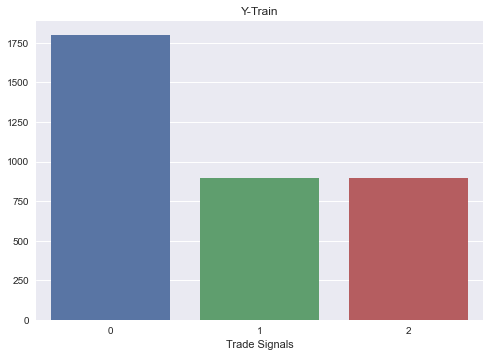

In [66]:
fig = sns.barplot(x=['0', '1', '2'],  y =[sum(ysmote['Recommender'] == 0), sum(ysmote['Recommender'] == 1), sum(ysmote['Recommender'] == 2)])
fig.set_title("Y-Train")
fig.set_xlabel('Trade Signals')

In [67]:
models = []
models.append(['Logistic Regreesion', LogisticRegression()])
models.append(['SVM', SVC()])
models.append(['KNeighbors', KNeighborsClassifier()])
models.append(['GaussianNB', GaussianNB()])
models.append(['Decision Tree', DecisionTreeClassifier()])
models.append(['Random Forest', RandomForestClassifier()])
models.append(['MLP', MLPClassifier()])


list_1= []

for m in range(len(models)):
    list_2= []
    
    model = models[m][1]
    model.fit(Xsmote, ysmote)
    y_pred = model.predict(X_test)

    #Accuracy
    accuracy = accuracy_score(y_pred , y_test.values.ravel())
    print(accuracy)
    #Precision
    test_precision = precision_score(y_test, y_pred,  average='macro')
    print("Test Data Precision Score :", test_precision) 
    #Recall
    test_recall = recall_score(y_test, y_pred,  average='macro')
    print("Test Data Recall Score : ", test_recall)
    #F1 Score
    test_f1 = f1_score(y_test, y_pred,average='macro')
    print("Test  Data F1 Score: ", test_f1)

    list_2.append(models[m][0])
    list_2.append(accuracy) 
    list_2.append(test_precision)
    list_2.append(test_recall)
    list_2.append(test_f1)
    list_1.append(list_2)





C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8653333333333333
Test Data Precision Score : 0.6990578865578866
Test Data Recall Score :  0.8907189542483659
Test  Data F1 Score:  0.7587712719453448


C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8853333333333333
Test Data Precision Score : 0.7312473011529877
Test Data Recall Score :  0.8780205415499532
Test  Data F1 Score:  0.7853137702929608
0.8933333333333333
Test Data Precision Score : 0.7577624989389694
Test Data Recall Score :  0.8898450046685341
Test  Data F1 Score:  0.8081874225406315
0.816
Test Data Precision Score : 0.6440527496865526
Test Data Recall Score :  0.8636339869281047
Test  Data F1 Score:  0.7036856337929303


C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9133333333333333
Test Data Precision Score : 0.7899808557302702
Test Data Recall Score :  0.8433874883286648
Test  Data F1 Score:  0.8120686331212648


C:\Users\RAHUL\AppData\Local\Temp/ipykernel_22376/1504728737.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(Xsmote, ysmote)


0.9386666666666666
Test Data Precision Score : 0.8379267005291867
Test Data Recall Score :  0.8730084033613444
Test  Data F1 Score:  0.8508196864753156


C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8853333333333333
Test Data Precision Score : 0.7420996231789037
Test Data Recall Score :  0.8632567693744164
Test  Data F1 Score:  0.7905123893941365


C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [68]:
#Displaying all the results from the model
model_results = pd.DataFrame(list_1, columns= ['Models with SMOTE 2', 'Accuracy', 'Precision', 'Recall', 'F1'])
model_results.sort_values(by= ['F1'], inplace= True, ascending= False)
model_results

,Models with SMOTE 2,Accuracy,Precision,Recall,F1
5,Random Forest,0.938667,0.837927,0.873008,0.850820
4,Decision Tree,0.913333,0.789981,0.843387,0.812069
2,KNeighbors,0.893333,0.757762,0.889845,0.808187
6,MLP,0.885333,0.742100,0.863257,0.790512
1,SVM,0.885333,0.731247,0.878021,0.785314
0,Logistic Regreesion,0.865333,0.699058,0.890719,0.758771
3,GaussianNB,0.816000,0.644053,0.863634,0.703686


Hyperparameter Tuning The Best Performing Model: Random Forest

In [73]:
X.shape


(2497, 12)

In [74]:
y.shape

(2497, 1)

In [77]:
#This Setup Achieved best performing model, we are running it again to check the models parameteres.

#SKFOLD Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
k = 10


#Random Forest
rf= RandomForestClassifier()

acc_score = []
prec_score = []
rec_score = []
f1_scor = []
 

for train_index , test_index in skf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]

    #Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    

    oversample = SMOTE()
    Xsmote, ysmote = oversample.fit_resample(X_train, y_train)  
     
    rf.fit(Xsmote,ysmote.values.ravel())
    y_pred = rf.predict(X_test)

    #Accuracy Score 
    acc = accuracy_score(y_pred , y_test)
    acc_score.append(acc)
    #Precision
    precision = precision_score(y_test, y_pred,  average='macro')
    prec_score.append(precision)
    #Recall
    recall = recall_score(y_test, y_pred,  average='macro')
    rec_score.append(recall)
    #F1 Score
    f1 = f1_score(y_test, y_pred,average='macro')
    f1_scor.append(f1)

#Displaying Results    
avg_acc_score = sum(acc_score)/k
avg_acc_score = round(avg_acc_score, 4)
print('Accuracy of each fold - {}'.format(acc_score))

avg_prec_score = sum(prec_score)/k
avg_prec_score = round(avg_prec_score, 4)
print('Precision of each fold - {}'.format(prec_score))

avg_rec_score = sum(rec_score)/k
avg_rec_score = round(avg_rec_score, 4)
print('Recall of each fold - {}'.format(rec_score))

avg_f1_score = sum(f1_scor)/k
avg_f1_score = round(avg_f1_score, 4)
print('F1 of each fold - {}'.format(f1_scor))

print("Avg Accuracy Score: ", avg_acc_score)
print("Avg Recall Score: ", avg_rec_score)
print("Avg Precision Score: ", avg_prec_score)
print("Avg F1 Score: ", avg_f1_score)







Accuracy of each fold - [0.952, 0.928, 0.944, 0.952, 0.928, 0.924, 0.948, 0.9357429718875502, 0.963855421686747, 0.9477911646586346]
Precision of each fold - [0.9051155115511551, 0.810763888888889, 0.8746107693476115, 0.8677528490028491, 0.8216690414326823, 0.7912309294218843, 0.8756875687568756, 0.8598180283931671, 0.927412334729408, 0.8238367064521709]
Recall of each fold - [0.910081585081585, 0.9138422688422688, 0.9353846153846154, 0.9444832944832945, 0.906961926961927, 0.8193861693861694, 0.8847871837821587, 0.8380714762624311, 0.9139247129196878, 0.9713524889404286]
F1 of each fold - [0.9065714903742158, 0.8530066347526665, 0.9006556592486241, 0.9024943310657596, 0.857848496680984, 0.8023725981620718, 0.8749961515963179, 0.8458815800279216, 0.91982427731798, 0.8753618960295629]
Avg Accuracy Score:  0.9423
Avg Recall Score:  0.9038
Avg Precision Score:  0.8558
Avg F1 Score:  0.8739


In [84]:
#Independant and Dependent Variable
y=dataset.iloc[:,12:13] #Dependent variable
X=dataset.iloc[:,0:12] #Independent variable


#Spliting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

#Scaling
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

oversample = SMOTE()
Xsmote, ysmote = oversample.fit_resample(X_train, y_train)

In [85]:
ysmote['Recommender'].value_counts()

0    1401
2    1401
1    1401
Name: Recommender, dtype: int64

In [78]:
# Look at parameters used by our current RF Model
print('Parameters currently in use:\n')
print(rf.get_params())


Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [86]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf= RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(Xsmote, ysmote)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\RAHUL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)